In [0]:
import torch
import random
import numpy as np

import torchvision.datasets
# from torchvision.models import resnet18
from torchsummary import summary

In [0]:
n_seed = 1
random.seed(n_seed)
np.random.seed(n_seed)
torch.manual_seed(n_seed)
torch.cuda.manual_seed(n_seed)
torch.backends.cudnn.deterministic = True


---

**CIFAR DATASET**


---


In [0]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [0]:
len(y_train), len(y_test)
X_train.min(), X_train.max() 
CIFAR_train.classes
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [0]:
# PyTorch requeres tensor with [img_numbers, channels, height, width]
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [0]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)

        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        
        self.fc3   = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)
        
        return x

In [0]:
def train(net, X_train, y_train, X_test, y_test, value=None):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)

    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    if value is not None:
      optimizer = torch.optim.Adam(net.parameters(), 
                                   lr=1.0e-3, weight_decay=value)
    
    batch_size = 64

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(50):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
          optimizer.zero_grad()
          net.train()

          batch_indexes = order[start_index:start_index+batch_size]

          X_batch = X_train[batch_indexes].to(device)
          y_batch = y_train[batch_indexes].to(device)

          preds = net.forward(X_batch) 

          loss_value = loss(preds, y_batch)
          loss_value.backward()

          optimizer.step()

        net.eval()

        # test_preds = net.forward(X_test)
        # test_loss_history.append(loss(test_preds, y_test).data.cpu())

        # accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        # test_accuracy_history.append(accuracy)

        with torch.no_grad():
          test_preds = net.forward(X_test)
          loss_value = loss(test_preds, y_test).item()
          test_loss_history.append(loss_value)

          accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
          test_accuracy_history.append(accuracy)

        print(epoch, accuracy)
    print('---------------')
    return test_accuracy_history, test_loss_history

**ResNet20**

In [0]:
class ResidualBlock(torch.nn.Module):
  expansion = 1

  def __init__(self, in_channels, out_channels, stride=1, drop=False, drop_p=0.5):
    super(ResidualBlock, self).__init__()

    self.drop_p = drop_p
    self.drop = torch.nn.Sequential()
    if drop:
      self.drop = torch.nn.Dropout2d(p=self.drop_p)

    self.conv1 = torch.nn.Conv2d(
        in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
    
    self.bn1 = torch.nn.BatchNorm2d(out_channels)
    self.act1 = torch.nn.ReLU()

    self.conv2 = torch.nn.Conv2d(
        out_channels, out_channels, 3, stride=1, padding=1, bias=False)
    
    self.bn2 = torch.nn.BatchNorm2d(out_channels)
    self.act2 = torch.nn.ReLU()

    self.res = torch.nn.Sequential()
    if stride != 1 or in_channels != out_channels:
      self.res = torch.nn.Sequential(
                     torch.nn.Conv2d(in_channels, self.expansion * out_channels, 
                                     kernel_size=1, stride=stride, bias=False),
                     torch.nn.BatchNorm2d(self.expansion * out_channels)
                )

  def forward(self, x):
    residual = x
    
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.drop(out)
    out = self.act1(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.drop(out)

    out += self.res(residual)

    out = self.act2(out)

    return out


class ResNet(torch.nn.Module):
  def __init__(self, block, num_blocks, num_classes=10, drop=False, drop_p=0.5):
    super(ResNet, self).__init__()

    self.out_channels = 64

    self.drop_p = drop_p
    self.drop = torch.nn.Sequential()
    if drop:
      self.drop = torch.nn.Dropout2d(p=self.drop_p)

    self.conv = torch.nn.Conv2d(
        3, self.out_channels, kernel_size=7, stride=2, padding=3, bias=False)
    
    self.bn = torch.nn.BatchNorm2d(self.out_channels)
    self.act = torch.nn.ReLU()
    self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(block, 64, num_blocks[0])
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

    self.avgpool = torch.nn.AvgPool2d((1, 1))
    self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

  def _make_layer(self, block, out_channels, num_blocks, stride=1):
    layers = []
    layers.append(block(self.out_channels, out_channels, 
                        stride, self.drop, self.drop_p))

    for _ in range(1, num_blocks):
      layers.append(block(out_channels, out_channels, 
                          drop=self.drop, drop_p=self.drop_p))
      
    self.out_channels = out_channels * block.expansion

    return torch.nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = self.drop(x)
    x = self.act(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)

    return x

In [0]:
accuracies = {}
losses = {}

accuracies['resnet20'], losses['resnet20'] = \
  train(ResNet(ResidualBlock, [3, 3, 2, 2]), X_train, y_train, X_test, y_test)

accuracies['resnet20_drop_0.5'], losses['resnet20_drop_0.5'] = \
  train(ResNet(ResidualBlock, [3, 3, 2, 2], drop=True), X_train, y_train, X_test, y_test)

accuracies['resnet20_drop_0.2'], losses['resnet20_drop_0.2'] = \
  train(ResNet(ResidualBlock, [3, 3, 2, 2], drop=True, drop_p=0.2), X_train, y_train, X_test, y_test)

accuracies['resnet20_drop_0.7'], losses['resnet20_drop_0.7'] = \
  train(ResNet(ResidualBlock, [3, 3, 2, 2], drop=True, drop_p=0.7), X_train, y_train, X_test, y_test)

In [0]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (13.0, 7.0)

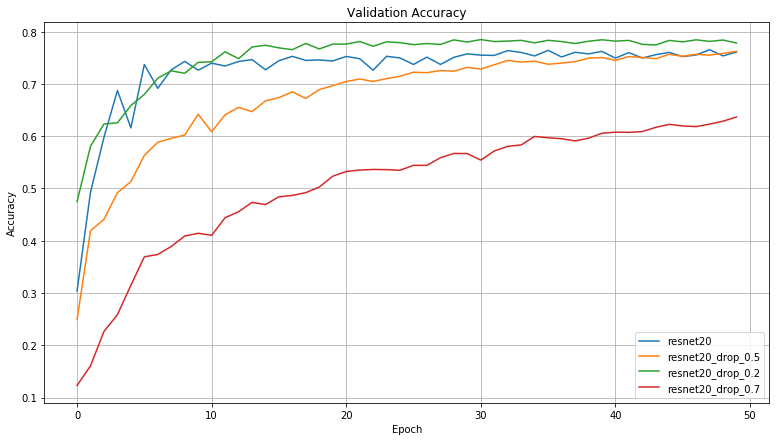

In [0]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy');

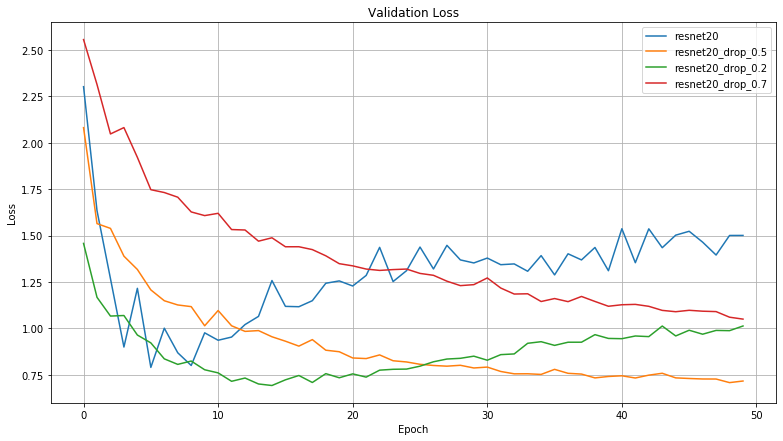

In [0]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss');

**L2-Regularization**

In [0]:
accuracies = {}
losses = {}

weight_decay = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

for index in range (0, 5):
  accuracies[str(weight_decay[index])], losses[str(weight_decay[index])] = \
    train(ResNet(ResidualBlock, [3, 3, 2, 2], drop=True, drop_p=0.2), 
          X_train, y_train, X_test, y_test, weight_decay[index])

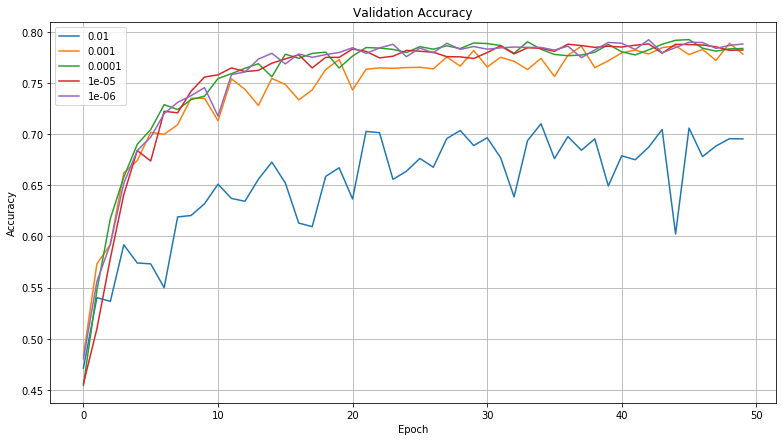

In [0]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy');

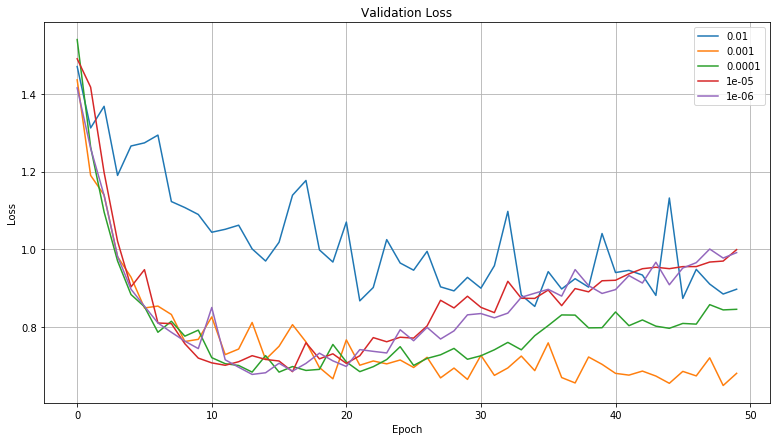

In [0]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss');

**ResNet110**

In [0]:
class AdvResBlock(torch.nn.Module):
  expansion = 4

  def __init__(self, in_channels, out_channels, stride=1, batch_norm=True):
    super(AdvResBlock, self).__init__()

    # self.batch_norm = batch_norm

    self.conv1 = torch.nn.Conv2d(
        in_channels, out_channels, 1, stride=1,bias=False)
    
    # self.bn = torch.nn.Sequential()
    # self.bn3 = torch.nn.Sequential()
    # if batch_norm:
    #   self.bn = torch.nn.BatchNorm2d(out_channels)
    #   self.bn3 = torch.nn.BatchNorm2d(out_channels * self.expansion)

    self.bn = torch.nn.BatchNorm2d(out_channels)
    self.bn3 = torch.nn.BatchNorm2d(out_channels * self.expansion)

    self.act1 = torch.nn.ReLU()

    self.conv2 = torch.nn.Conv2d(
        out_channels, out_channels, 3, stride=stride, padding=1, bias=False)
    
    self.act2 = torch.nn.ReLU()

    self.conv3 = torch.nn.Conv2d(
        out_channels, out_channels * self.expansion, 1, stride=1, bias=False)
    
    self.act3 = torch.nn.ReLU()

    self.res = torch.nn.Sequential()
    if stride != 1 or in_channels != out_channels * self.expansion:
      self.res = torch.nn.Sequential(
                     torch.nn.Conv2d(in_channels, out_channels * self.expansion, 
                                     kernel_size=1, stride=stride, bias=False),
                     torch.nn.BatchNorm2d(out_channels * self.expansion)
                )
      
  def forward(self, x):
    residual = x
    
    out = self.conv1(x)
    out = self.bn(out)
    out = self.act1(out)

    out = self.conv2(out)
    out = self.bn(out)
    out = self.act2(out)

    out = self.conv3(out)
    out = self.bn3(out)
    out += self.res(residual)

    out = self.act3(out)
    return out


class ResNet110(torch.nn.Module):
  def __init__(self, block, num_blocks, num_classes=10, batch_norm=True):
    super(ResNet110, self).__init__()

    self.out_channels = 64

    # self.batch_norm = batch_norm

    self.conv = torch.nn.Conv2d(
        3, self.out_channels, kernel_size=7, stride=2, padding=3, bias=False)
    
    self.bn = torch.nn.BatchNorm2d(self.out_channels)    
    # self.bn = torch.nn.Sequential()
    # if self.batch_norm:
    #   self.bn = torch.nn.BatchNorm2d(self.out_channels)

    self.act = torch.nn.ReLU()
    self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(block, 64, num_blocks[0])
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

    self.avgpool = torch.nn.AvgPool2d((1, 1))
    self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

  def _make_layer(self, block, out_channels, num_blocks, stride=1):
    layers = []
    layers.append(block(self.out_channels, out_channels, stride))
    self.out_channels = out_channels * block.expansion

    for _ in range(1, num_blocks):
      layers.append(block(self.out_channels, out_channels))

    return torch.nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = self.act(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
    x = self.fc(x)

    return x

In [0]:
from torchvision.models import resnet101

accuracies = {}
losses = {}

# accuracies['resnet101'], losses['resnet101'] = \
#   train(resnet101(), X_train, y_train, X_test, y_test)

accuracies['resnet101_my'], losses['resnet101_my'] = \
  train(ResNet110(AdvResBlock, [3, 4, 23, 3]), X_train, y_train, X_test, y_test)

accuracies['resnet110_BN'], losses['resnet110_BN'] = \
  train(ResNet110(AdvResBlock, [3, 4, 26, 3]), X_train, y_train, X_test, y_test)

# for seed in range(10):
#   random.seed(seed)
#   np.random.seed(seed)
#   torch.manual_seed(seed)
#   torch.cuda.manual_seed(seed)

#   accuracies['resnet110_' + str(seed)], losses['resnet110_' + str(seed)] = \
#     train(ResNet110(AdvResBlock, [3, 5, 25, 3], batch_norm=False), X_train, y_train, X_test, y_test)

0 0.1454000025987625
1 0.10839999467134476
2 0.24849998950958252
3 0.13570000231266022
4 0.10740000009536743
5 0.1655000001192093
6 0.2565000057220459
7 0.12879998981952667
8 0.3578999936580658
9 0.3928000032901764
10 0.38269999623298645
11 0.29330000281333923
12 0.4059999883174896
13 0.436599999666214
14 0.4876999855041504
15 0.483599990606308
16 0.46559998393058777
17 0.4324999749660492
18 0.43199998140335083
19 0.26729997992515564
20 0.48539999127388
21 0.3130999803543091
22 0.44589999318122864
23 0.4504999816417694
24 0.41609999537467957
25 0.4514999985694885
26 0.5325999855995178
27 0.4521999955177307
28 0.4494999945163727
29 0.47029998898506165
30 0.40230000019073486
31 0.37610000371932983
32 0.4212999939918518
33 0.5728999972343445
34 0.5532000064849854
35 0.5069000124931335
36 0.5187000036239624
37 0.4197999835014343
38 0.4878000020980835
39 0.4731999933719635
40 0.5080999732017517
41 0.5180000066757202
42 0.5056999921798706
43 0.5564999580383301
44 0.5029999613761902
45 0.4086